# Import needed libraries
To make things work ensure that you have this libraries installed.

In [2]:
# imports
import os
import numpy as np
import splitfolders
from tqdm import tqdm
import seaborn as sns
import tensorflow as tf
from string import digits
from imutils import paths
from random import choices
from typing import Tuple, List
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K
from tensorflow.data import AUTOTUNE
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from tensorflow.keras.metrics import CategoricalAccuracy
from tensorflow.keras.losses import CategoricalCrossentropy
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.layers import GRU, Dense, Bidirectional, InputLayer, Reshape

2024-04-26 11:06:14.587395: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-26 11:06:14.587496: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-26 11:06:14.743878: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# Data
The **Dataset** class is designed as a helper tool for loading and preparing image datasets for training machine learning models.

In [4]:
class Dataset:

    MAX_IMAGES_PER_GENRE = 5_000
    
    def __init__(self, path: str, output: str | None = None, ratio: Tuple[float, float, float] = (.70, .15, .15), split: bool = True, split_folders: bool = False, image_size: Tuple[int, int] = (224,224), batch_size: int = 8 , cache: bool = True):
        assert sum(ratio) == 1.0

        self.path = path
        self.labels = [name for name in tqdm(os.listdir(self.path)) if os.path.isdir(os.path.join(self.path, name))]
        
        self.cache = cache
        self.ratio = ratio
        
        self.output_path = output if output else f"./data-{''.join(choices(digits, k=5))}"
        
        self.train = os.path.sep.join([self.output_path, 'train'])
        self.val = os.path.sep.join([self.output_path, 'val'])
        self.test = os.path.sep.join([self.output_path, 'test'])
        
        self.image_size = image_size
        self.batch_size = batch_size
        
        assert split == True or split_folders == True or output is not None
        
        if split:
            self.__split()
        elif split_folders:
            self.__split_folder()
            
        self.__generate()
    
    def __split(self):
        tmp_ratio = (1.0 - self.ratio[0])
        val_test_ratio = self.ratio[1] / tmp_ratio
        
        def get_genres(path):
            genres = {}
            for image_path in tqdm(list(paths.list_images(path))):
                genre = os.path.basename(os.path.dirname(image_path))

                if genre not in genres:
                    genres[genre] = []
                
                if len(genres[genre]) >= Dataset.MAX_IMAGES_PER_GENRE:
                    continue
                
                genres[genre].append(image_path)
            
            return genres

        
        def split_genre(genre):
            train, tmp = train_test_split(genre, test_size=tmp_ratio, random_state=42)
            test, val = train_test_split(tmp, test_size=val_test_ratio, random_state=42)
            
            return train, val, test
        
        self.train, self.val, self.test = [], [], []
        genres = get_genres(self.path)
        for genre in genres.values():
            train, val, test = split_genre(genre)
            self.train.extend(train)
            self.val.extend(val)
            self.test.extend(test)
    
        np.random.shuffle(self.train)
        np.random.shuffle(self.val)
        np.random.shuffle(self.test)
    
    def __split_folder(self):
        splitfolders.ratio(self.path, output=self.output_path, seed=42, ratio=self.ratio, group_prefix=None)
    
    def __generate(self):
        def load_images(image_path):
            image = tf.io.read_file(image_path)
            image = tf.image.decode_png(image, channels=3)
            image = tf.image.convert_image_dtype(image, dtype=tf.float32)
            image = tf.image.resize(image, self.image_size)
            
            label = tf.strings.split(image_path, os.path.sep)[-2]
            label = tf.cast(tf.equal(self.labels, label), tf.int32)
    
            return (image, label)
        
        def get_paths(x):
            if isinstance(x, str):
                return paths.list_images(x)
            else:
                return x
        
        train_paths = get_paths(self.train)
        self.train_len = len(train_paths) // self.batch_size
        self.train = tf.data.Dataset.from_tensor_slices(train_paths)
        self.train = (self.train
            .shuffle(len(train_paths), reshuffle_each_iteration=True)
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.train = self.train.cache()
        
        val_paths = get_paths(self.val)
        self.val_len = len(val_paths) // self.batch_size
        self.val = tf.data.Dataset.from_tensor_slices(val_paths)
        self.val = (self.val
            .shuffle(len(val_paths))
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .repeat(-1)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.val = val.train.cache()
        
        test_paths = get_paths(self.test)
        self.test_len = len(test_paths) // self.batch_size
        self.test = tf.data.Dataset.from_tensor_slices(test_paths)
        self.test = (self.test
            .map(load_images, num_parallel_calls=AUTOTUNE)
            .batch(self.batch_size)
            .prefetch(AUTOTUNE)
        )
        
        if self.cache:
            self.test = self.test.cache()

# Helper functions
The following functions are helpful tools for visualising model training progress and evaluating model performance through confusion matrix analysis.

In [5]:
def plot_history(history, metric: str = '', ylim: List[float] | None = None):
    h = history.history
    plt.figure(figsize=(15,5))
    plt.plot(h[metric])
    plt.plot(h[f'val_{metric}'])
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend([metric, f'val_{metric}'], loc='upper left')
    if ylim:
        axes = plt.gca()
        axes.set_ylim(ylim)
    plt.show()
    
def show_confusion_matrix(y_true, y_pred, labels: List[str] = []):
    matrix = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(len(labels), len(labels)))
    hm = sns.heatmap(matrix,
                cmap='coolwarm',
                linecolor='white',
                linewidths=1,
                xticklabels=labels,
                yticklabels=labels,
                annot=True,
                fmt='d')
    plt.yticks(rotation = 0)
    hm.set_ylim(0, len(matrix))
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

# Bi-GRU 
The **build_model** function is a utility designed to construct and compile a model. The **STFT** and **Mel Spectrogram** are used to learn this model.

In [6]:
def build_model(height: int = 224, width: int = 224, channels: int = 3, genres: int = 10):
    input_shape = (channels, height, width) if  K.image_data_format() == 'channels_first' else (height, width, channels)
    
    # Create the model
    model = Sequential()
    model.add(InputLayer(shape=input_shape))
    model.add(Reshape((width, height * channels)))
    model.add(Bidirectional(GRU(256)))
    model.add(Dense(256, activation='elu'))
    model.add(Dense(genres, activation='softmax'))

    # Compile the model
    model.compile(
        optimizer=Adam(learning_rate=0.0001),
        loss=CategoricalCrossentropy(),
        metrics=[
            CategoricalAccuracy(name='accuracy')
        ])
    
    return model

# GTZAN 

## Short-Time Fourier Transform

In [33]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/stft', batch_size=batch_size)

Copying files: 4995 files [00:11, 429.91 files/s]


In [35]:
model = build_model()

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 7s 45ms/step - accuracy: 0.1741 - loss: 2.1956 - val_accuracy: 0.3003 - val_loss: 1.8923
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3137 - loss: 1.8621 - val_accuracy: 0.3180 - val_loss: 1.7183
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3387 - loss: 1.7285 - val_accuracy: 0.3431 - val_loss: 1.6692
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3575 - loss: 1.6729 - val_accuracy: 0.3821 - val_loss: 1.6140
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3901 - loss: 1.6223 - val_accuracy: 0.4170 - val_loss: 1.5716
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4139 - loss: 1.5739 - val_accuracy: 0.4351 - val_loss: 1.5412
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4361 - loss: 1.5225 - val_accuracy: 0.4589 - val_loss: 1.4995
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4617 - loss: 1.4601 - val_accu

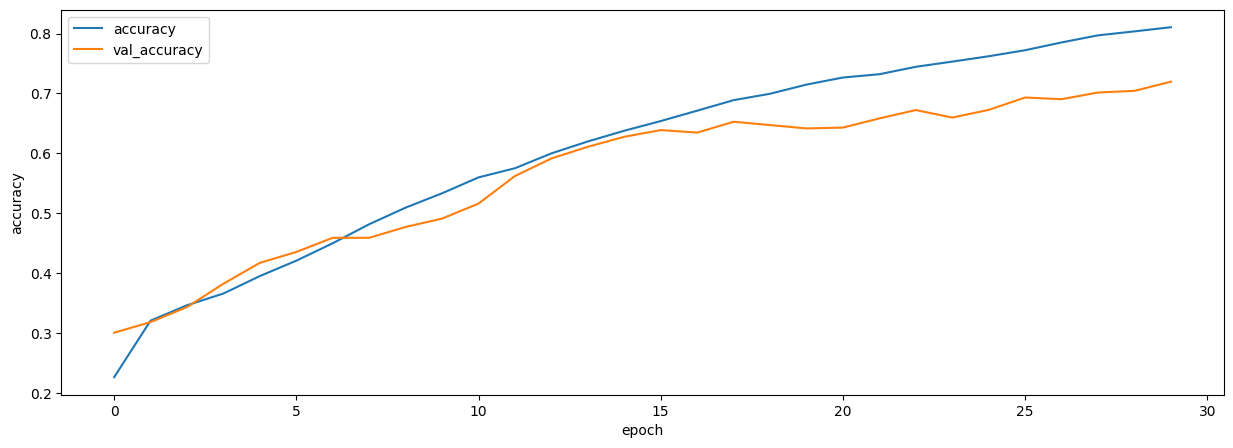

In [36]:
plot_history(history, metric='accuracy')

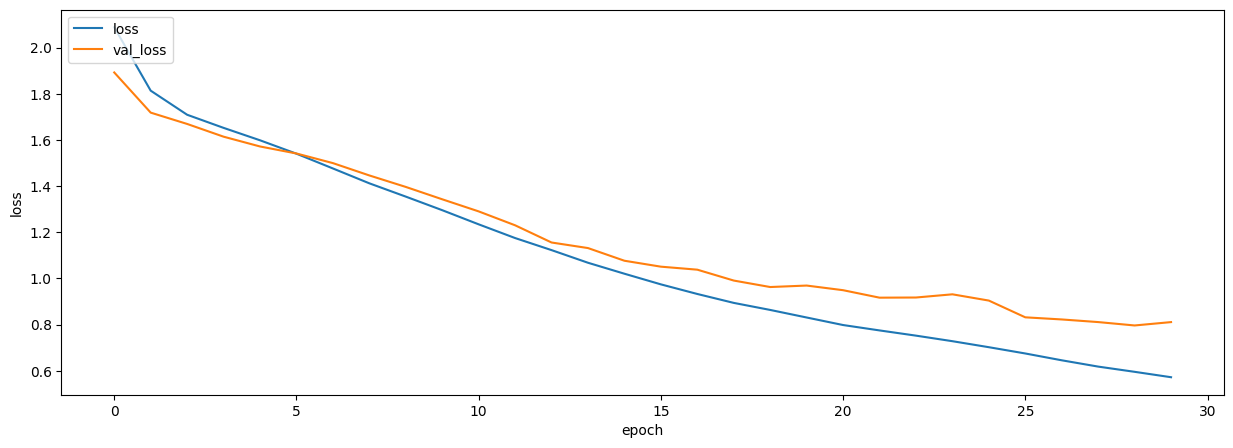

In [37]:
plot_history(history, metric='loss')

In [38]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - accuracy: 0.7437 - loss: 0.7928
Accuracy: 0.7146666646003723
Loss: 0.8462721705436707


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step


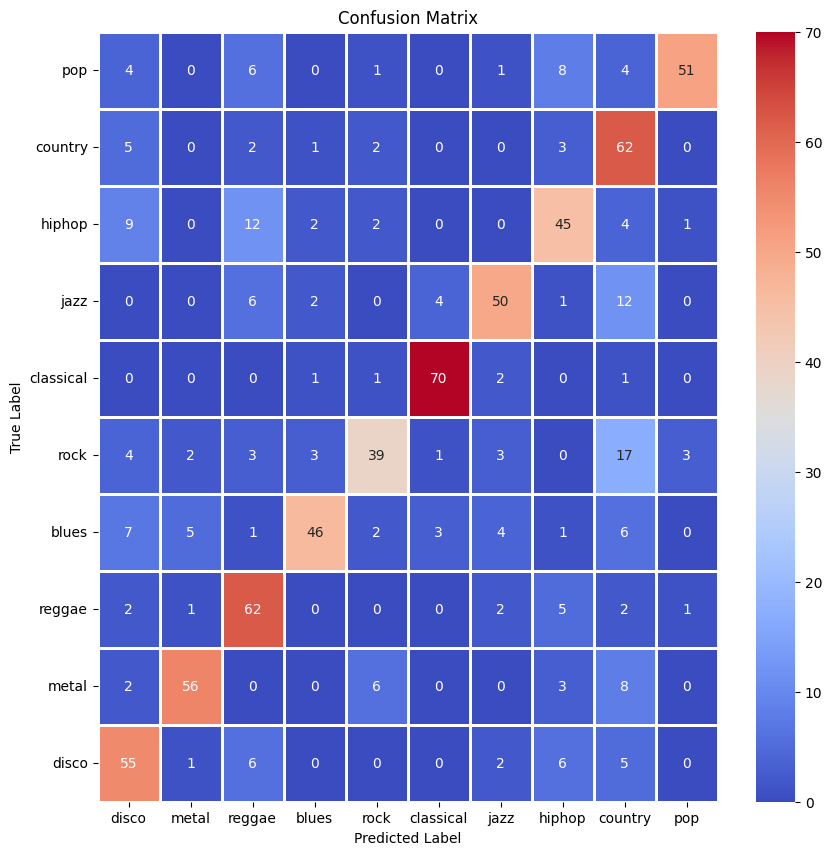

              precision    recall  f1-score   support

           0       0.62      0.73      0.67        75
           1       0.86      0.75      0.80        75
           2       0.63      0.83      0.72        75
           3       0.84      0.61      0.71        75
           4       0.74      0.52      0.61        75
           5       0.90      0.93      0.92        75
           6       0.78      0.67      0.72        75
           7       0.62      0.60      0.61        75
           8       0.51      0.83      0.63        75
           9       0.91      0.68      0.78        75

    accuracy                           0.71       750
   macro avg       0.74      0.71      0.72       750
weighted avg       0.74      0.71      0.72       750



In [39]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## Mel Spectogram

In [40]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/musicgenreprediction/Data/images_augmented/mel_spectrogram', batch_size=batch_size)

Copying files: 4995 files [00:43, 114.18 files/s]


In [41]:
model = build_model()

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 10s 71ms/step - accuracy: 0.2129 - loss: 2.1369 - val_accuracy: 0.3084 - val_loss: 1.8299
Epoch 2/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3287 - loss: 1.8064 - val_accuracy: 0.3612 - val_loss: 1.6883
Epoch 3/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.3730 - loss: 1.6730 - val_accuracy: 0.3933 - val_loss: 1.5767
Epoch 4/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4248 - loss: 1.5736 - val_accuracy: 0.4226 - val_loss: 1.4948
Epoch 5/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4475 - loss: 1.5019 - val_accuracy: 0.4421 - val_loss: 1.4474
Epoch 6/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4683 - loss: 1.4534 - val_accuracy: 0.4616 - val_loss: 1.4237
Epoch 7/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4783 - loss: 1.4169 - val_accuracy: 0.4826 - val_loss: 1.3884
Epoch 8/30
109/109 ━━━━━━━━━━━━━━━━━━━━ 5s 43ms/step - accuracy: 0.4964 - loss: 1.3690 - val_acc

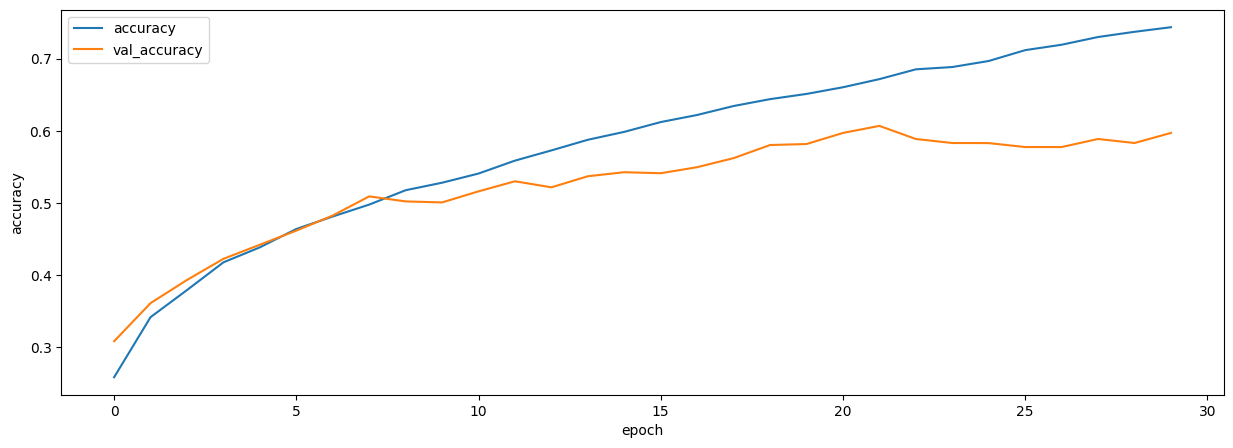

In [42]:
plot_history(history, metric='accuracy')

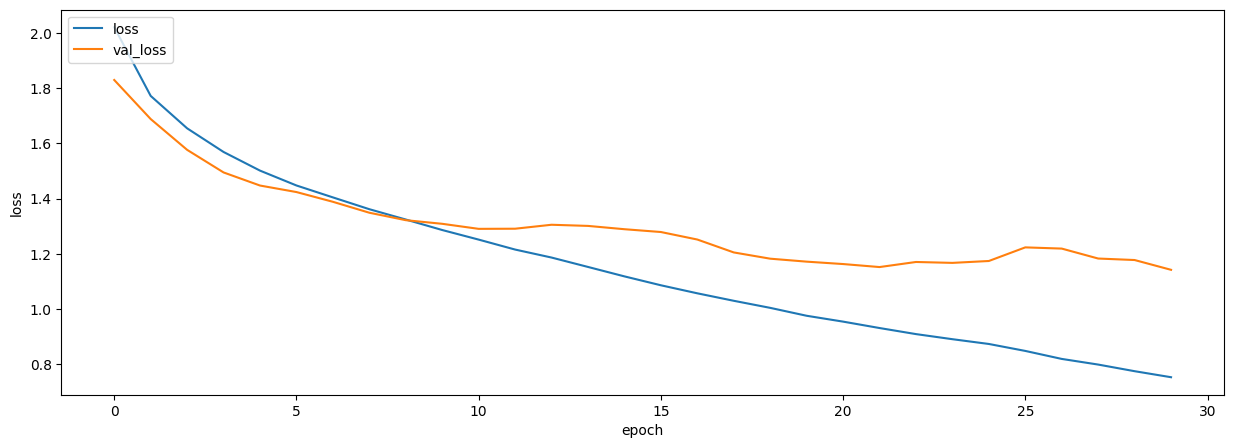

In [43]:
plot_history(history, metric='loss')

In [44]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 51ms/step - accuracy: 0.6017 - loss: 1.1328
Accuracy: 0.5920000076293945
Loss: 1.1120434999465942


24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step


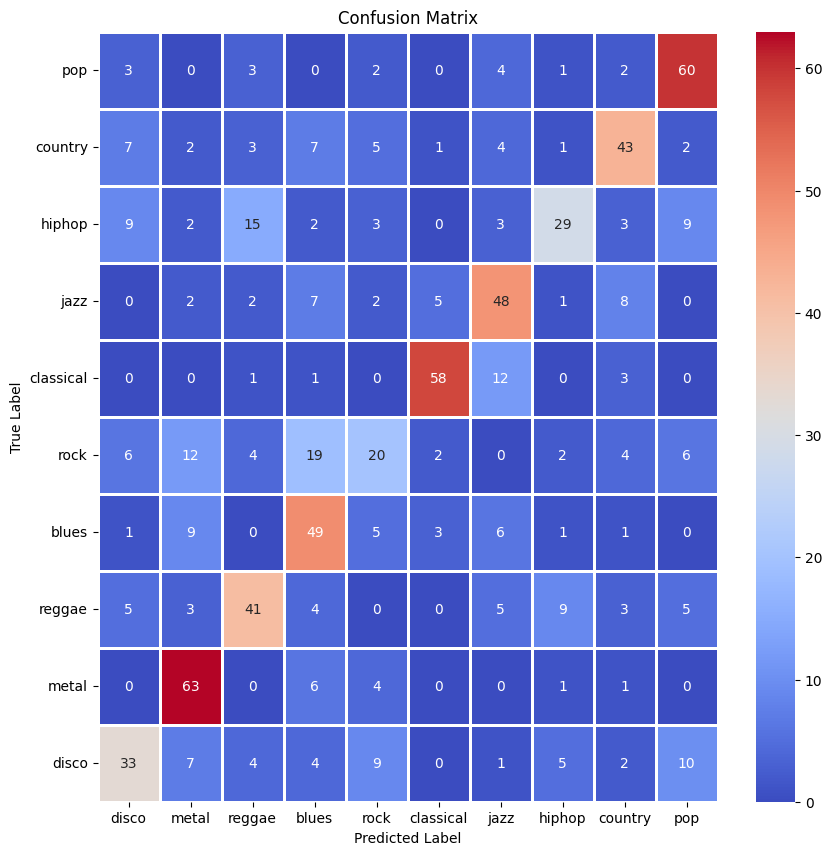

              precision    recall  f1-score   support

           0       0.52      0.44      0.47        75
           1       0.63      0.84      0.72        75
           2       0.56      0.55      0.55        75
           3       0.49      0.65      0.56        75
           4       0.40      0.27      0.32        75
           5       0.84      0.77      0.81        75
           6       0.58      0.64      0.61        75
           7       0.58      0.39      0.46        75
           8       0.61      0.57      0.59        75
           9       0.65      0.80      0.72        75

    accuracy                           0.59       750
   macro avg       0.59      0.59      0.58       750
weighted avg       0.59      0.59      0.58       750



In [45]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

# FMA

## Short-Time Fourier Transform

In [6]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/stft/stft', batch_size=batch_size, cache=False)

100%|██████████| 64846/64846 [00:00<00:00, 273153.48it/s]


In [7]:
model = build_model(genres=15)

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 136s 118ms/step - accuracy: 0.2559 - loss: 2.1932 - val_accuracy: 0.3893 - val_loss: 1.8667
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 85s 76ms/step - accuracy: 0.3986 - loss: 1.8311 - val_accuracy: 0.4136 - val_loss: 1.7906
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 85s 75ms/step - accuracy: 0.4376 - loss: 1.7284 - val_accuracy: 0.4439 - val_loss: 1.7072
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.4639 - loss: 1.6500 - val_accuracy: 0.4591 - val_loss: 1.6627
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 87s 77ms/step - accuracy: 0.4759 - loss: 1.6055 - val_accuracy: 0.4592 - val_loss: 1.6526
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 88s 79ms/step - accuracy: 0.4893 - loss: 1.5481 - val_accuracy: 0.4873 - val_loss: 1.5682
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 86s 77ms/step - accuracy: 0.5089 - loss: 1.5001 - val_accuracy: 0.4974 - val_loss: 1.5422
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 79s 71ms/step - accuracy: 0.5244

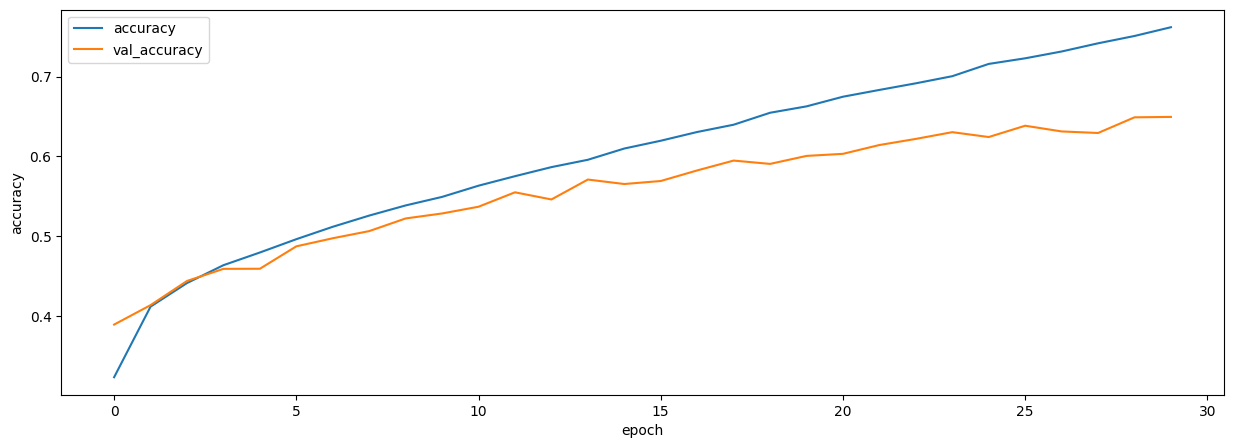

In [8]:
plot_history(history, metric='accuracy')

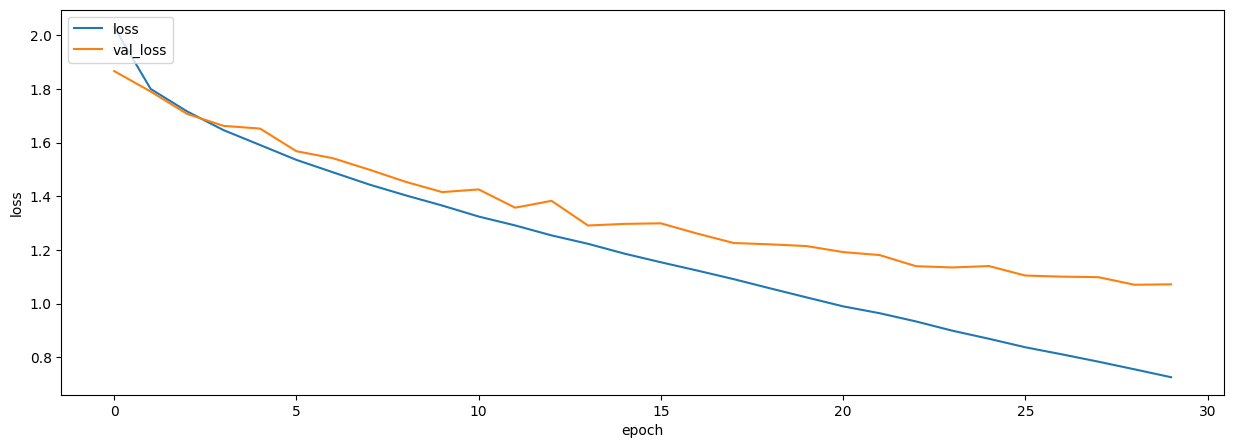

In [9]:
plot_history(history, metric='loss')

In [10]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 25s 102ms/step - accuracy: 0.6615 - loss: 1.0702
Accuracy: 0.6528946757316589
Loss: 1.0678775310516357


242/242 ━━━━━━━━━━━━━━━━━━━━ 14s 59ms/step


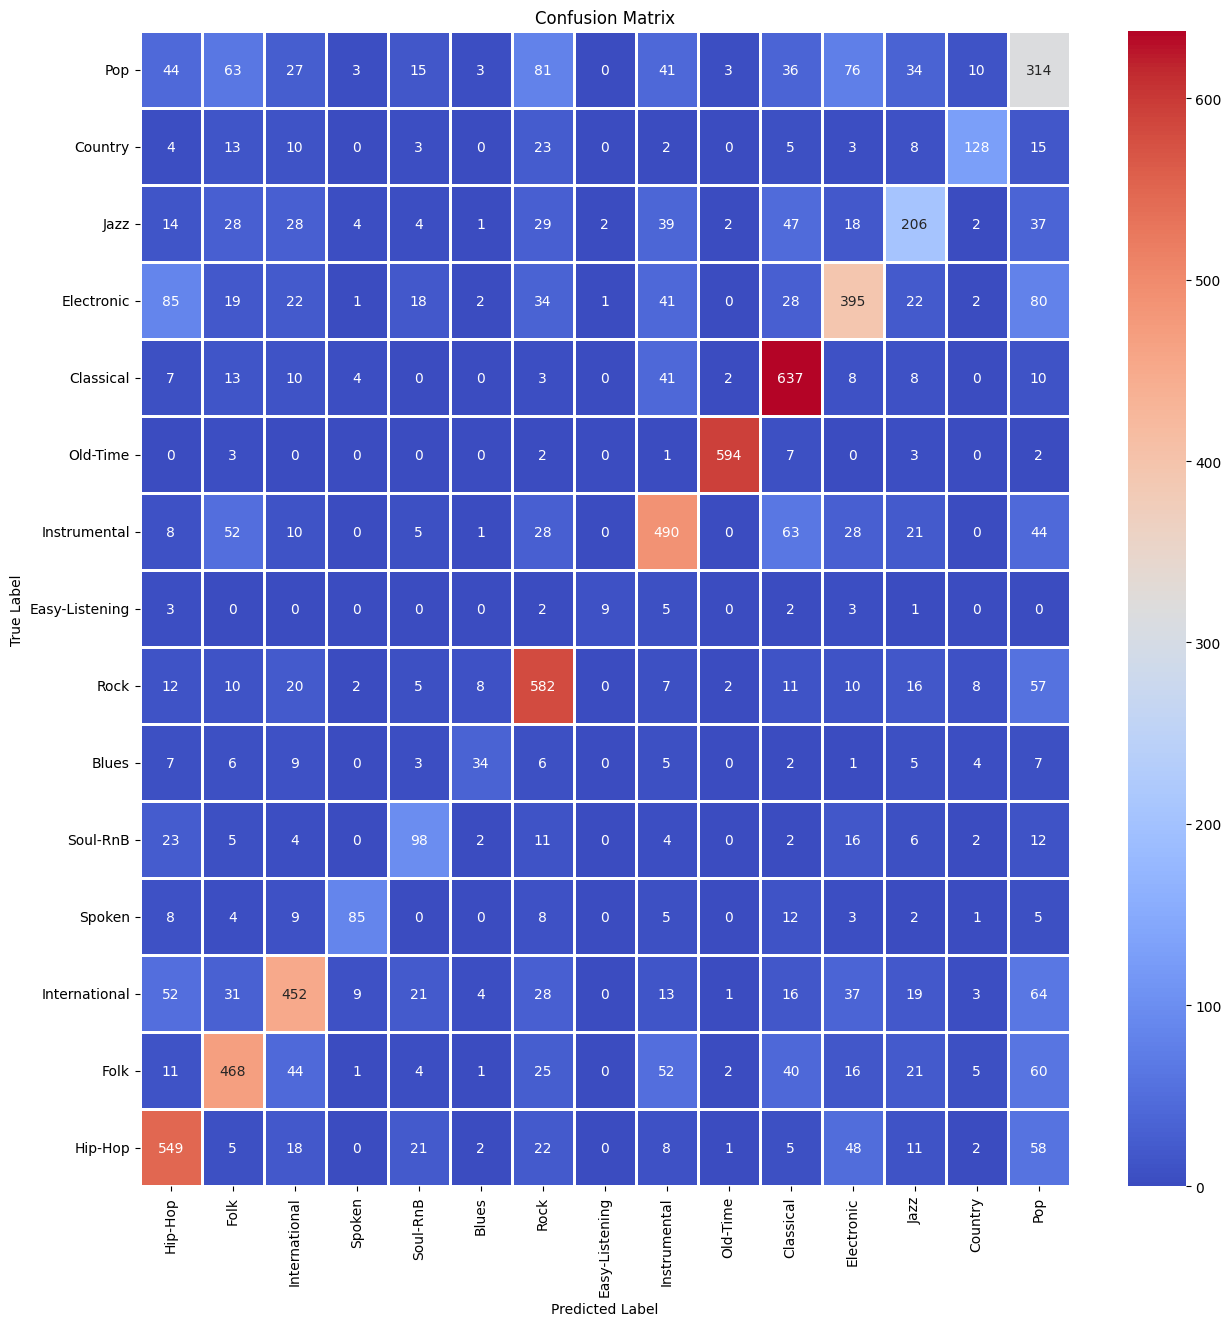

              precision    recall  f1-score   support

           0       0.66      0.73      0.70       750
           1       0.65      0.62      0.64       750
           2       0.68      0.60      0.64       750
           3       0.78      0.60      0.68       142
           4       0.50      0.53      0.51       185
           5       0.59      0.38      0.46        89
           6       0.66      0.78      0.71       750
           7       0.75      0.36      0.49        25
           8       0.65      0.65      0.65       750
           9       0.98      0.97      0.97       612
          10       0.70      0.86      0.77       743
          11       0.60      0.53      0.56       750
          12       0.54      0.45      0.49       461
          13       0.77      0.60      0.67       214
          14       0.41      0.42      0.41       750

    accuracy                           0.65      7721
   macro avg       0.66      0.61      0.62      7721
weighted avg       0.65   

In [11]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))

## Mel Spectogram

In [7]:
batch_size = 32
dataset = Dataset(path='/kaggle/input/fma-images/mel/mel', batch_size=batch_size, cache=False)

100%|██████████| 64842/64842 [00:00<00:00, 273534.41it/s]


In [8]:
model = build_model(genres=15)

epochs = 30

# Train the model using generator for training data and validation data
history = model.fit(dataset.train,
                    batch_size=batch_size,
                    epochs=epochs,
                    steps_per_epoch=dataset.train_len,
                    validation_data=dataset.val,
                    validation_steps=dataset.val_len,
                    verbose=1)

Epoch 1/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 146s 127ms/step - accuracy: 0.3041 - loss: 2.0832 - val_accuracy: 0.3839 - val_loss: 1.8767
Epoch 2/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 101s 90ms/step - accuracy: 0.4011 - loss: 1.8250 - val_accuracy: 0.4141 - val_loss: 1.7891
Epoch 3/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 90s 80ms/step - accuracy: 0.4299 - loss: 1.7242 - val_accuracy: 0.4374 - val_loss: 1.7281
Epoch 4/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 94s 83ms/step - accuracy: 0.4553 - loss: 1.6515 - val_accuracy: 0.4549 - val_loss: 1.6673
Epoch 5/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 93s 83ms/step - accuracy: 0.4745 - loss: 1.5957 - val_accuracy: 0.4741 - val_loss: 1.6149
Epoch 6/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 93s 83ms/step - accuracy: 0.4983 - loss: 1.5275 - val_accuracy: 0.4886 - val_loss: 1.5781
Epoch 7/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 96s 86ms/step - accuracy: 0.5021 - loss: 1.5032 - val_accuracy: 0.5038 - val_loss: 1.5279
Epoch 8/30
1125/1125 ━━━━━━━━━━━━━━━━━━━━ 92s 81ms/step - accuracy: 0.519

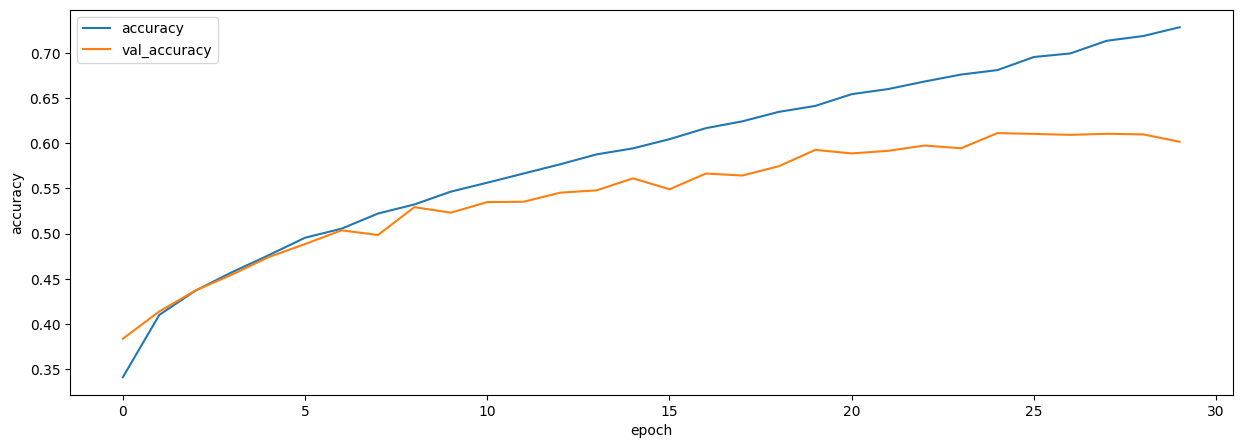

In [9]:
plot_history(history, metric='accuracy')

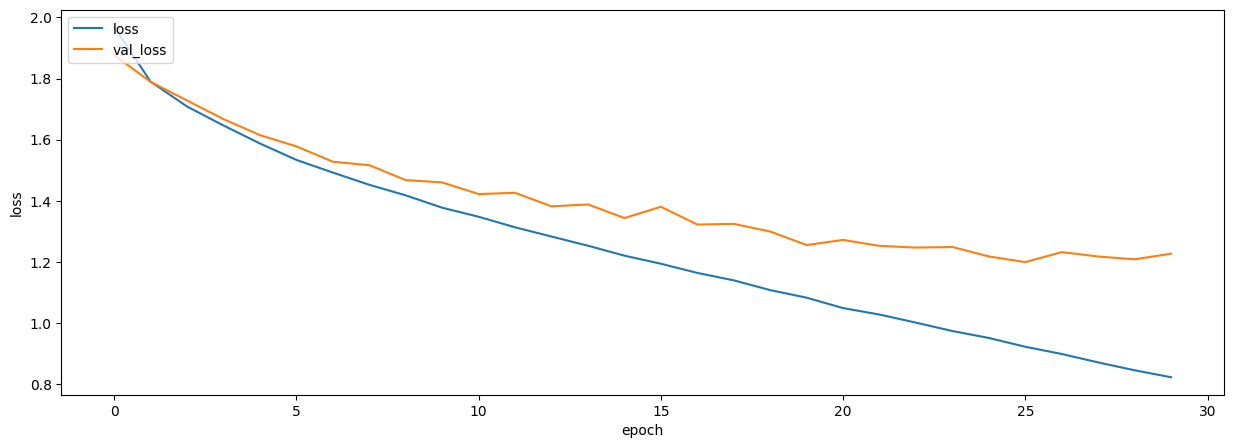

In [10]:
plot_history(history, metric='loss')

In [11]:
evaluation = model.evaluate(dataset.test, return_dict=True)
print(f'Accuracy: {evaluation["accuracy"]}')
print(f'Loss: {evaluation["loss"]}')

242/242 ━━━━━━━━━━━━━━━━━━━━ 27s 110ms/step - accuracy: 0.6118 - loss: 1.2363
Accuracy: 0.6085999011993408
Loss: 1.229475975036621


242/242 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step


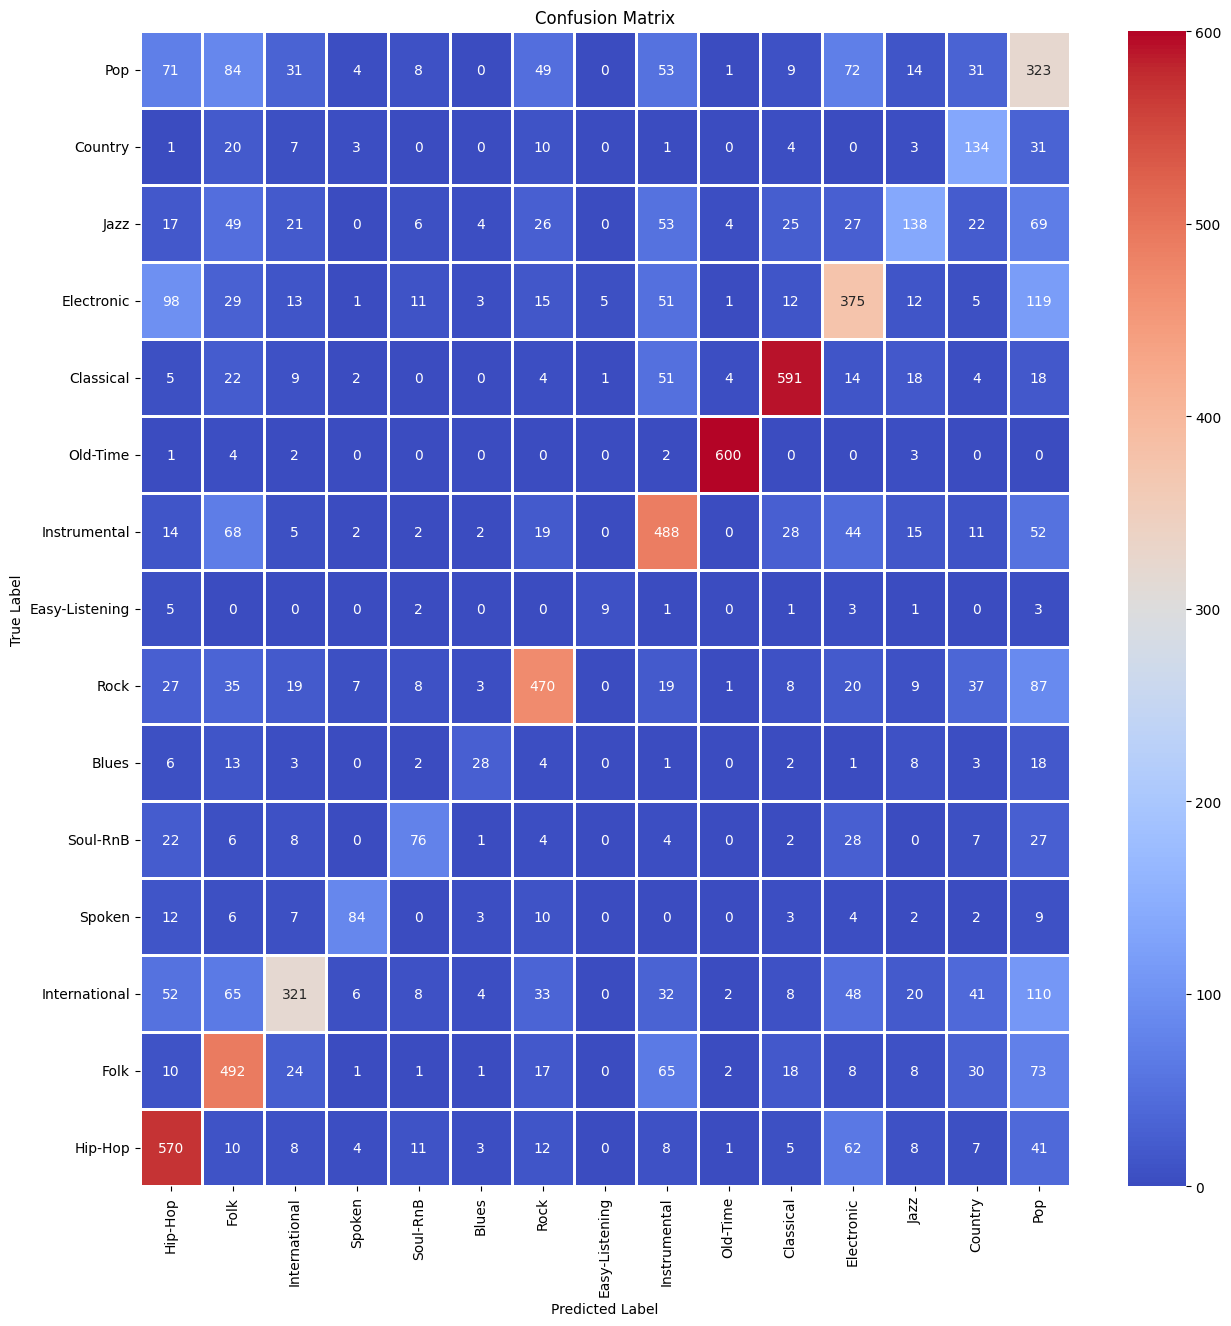

              precision    recall  f1-score   support

           0       0.63      0.76      0.69       750
           1       0.54      0.66      0.60       750
           2       0.67      0.43      0.52       750
           3       0.74      0.59      0.66       142
           4       0.56      0.41      0.48       185
           5       0.54      0.31      0.40        89
           6       0.70      0.63      0.66       750
           7       0.60      0.36      0.45        25
           8       0.59      0.65      0.62       750
           9       0.97      0.98      0.98       612
          10       0.83      0.80      0.81       743
          11       0.53      0.50      0.52       750
          12       0.53      0.30      0.38       461
          13       0.40      0.63      0.49       214
          14       0.33      0.43      0.37       750

    accuracy                           0.61      7721
   macro avg       0.61      0.56      0.57      7721
weighted avg       0.62   

In [12]:
y_pred = model.predict(dataset.test)
y_pred = np.argmax(y_pred, axis=1)
y_true = tf.concat([y for x, y in dataset.test], axis=0).numpy().argmax(axis=1)

show_confusion_matrix(y_true, y_pred, labels=dataset.labels)
print(classification_report(y_true, y_pred))